In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
%tensorflow_version 2.x
import tensorflow
tensorflow.__version__
import random
random.seed(0)
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import csv
import cv2 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [4]:
from numpy import load
X_train = load('/content/drive/My Drive/Colab Notebooks/x_train.npy')
X_val = load('/content/drive/My Drive/Colab Notebooks/x_val.npy')

y_train = load('/content/drive/My Drive/Colab Notebooks/y_train.npy')
y_val = load('/content/drive/My Drive/Colab Notebooks/y_val.npy')

In [23]:
project_path = '/content/drive/My Drive/Colab Notebooks/'
DATASET_FOLDER = project_path + "images/"
TRAIN_CSV = project_path + "images/train.csv"
VALIDATION_CSV = project_path + "images/validation.csv"

# Lets create the model in this part. We had created the train and test sets in the previous part

In [5]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Reshape

ALPHA = 1.0
#alpha denotes how much mobilenet should it take. If set 1.0, it will take all the activations and featuremaps of mobilenet(slower,more accurate).
#If we set 0.5 then it will take half the no. of feat maps and activations(faster,less accurate).

def create_model(trainable=True):
    model = MobileNet(input_shape=(128, 128, 3), include_top=False, alpha=ALPHA)
    # include_top=False means do not include classifier (top) layer. We will create that on our own

    for layer in model.layers:
        layer.trainable = trainable
        
    #This gives the final output of the mobilenet part untill now (without classifier). Output of this is 1024 x 4 x 4 
    #where 1024 is the no. of feature maps each of size 4x4. This is what mobilenet part gives.
    modeloutput_untill_now = model.layers[-1].output #1024x4x4

    #AN IMPORTANT POINT TO REMEMBER IN MOBILENET:
    #we have passed 128x128 input image hence we are getting featuremaps of 4x4. We know that mobilenet can take multiple image sizes.
    #so if we pass image of size 96x96 then this layer will give 3 x 3 x 1024. If 160x160 then 5 x 5 x 1024

    #This is the classifier part. Allthough we use fully connected layers in classifier but here we will do it the following way.
    #We will add a concolution layer of kernel 4x4 and no. featmaps=4 So 4x4 kernel on 4x4 featuremaps of previous layer will give 1x1
    #featuremaps which is nothing but a number(scalar). And we'll make 4 such 1x1 features maps. So output of this layer will be 1 x 1 x 4.
    ourlayer_1 = Conv2D(4, kernel_size=4, name="coords")(modeloutput_untill_now) #if image size is 96x96 then kernel=3, if 160x160 then kernel=5
    #This layer will take input of previous layer which is model_untill_now.

    # In this layer we are just reshaping the previous layer. We take the input of previous layer and reshape it from 1x1x4(1,4) to 4x1x1(4,1)
    ourlayer_2 = Reshape((4,))(ourlayer_1) # These are the 4 predicted coordinates of one BBox

    #This is how we initialize the model
    return Model(inputs=model.input, outputs=ourlayer_2)

Now we dont have IOU as default in sklearns metric so we will define our own IOU metric.

In [6]:
def intersec_over_uni(y_true, y_pred):

    true_BB = y_true #true x0,y0,w,h of all the images in the batch - array of shape: (batchsize,4)
    pred_BB = y_pred #predicted x0,y0,w,h of all the images in the batch  - array of shape: (batchsize,4)

    # finding interection of pred_bb and true_bb
    diff_width = np.minimum(true_BB[:,0] + true_BB[:,2], pred_BB[:,0] + pred_BB[:,2]) - np.maximum(true_BB[:,0], pred_BB[:,0])
    diff_height = np.minimum(true_BB[:,1] + true_BB[:,3], pred_BB[:,1] + pred_BB[:,3]) - np.maximum(true_BB[:,1], pred_BB[:,1])
    intersection = diff_width * diff_height

    # Computing union
    area_true = true_BB[:,2] * true_BB[:,3]
    area_pred = pred_BB[:,2] * pred_BB[:,3]
    union = area_true + area_pred - intersection

    # adding the intersections and unions of all the images in the batch
    total_intersections = 0
    total_unions = 0
    for idx, _ in enumerate(union):
      if union[idx] > 0 and intersection[idx] > 0 and union[idx] >= intersection[idx]: #this is just a small check, intersection and union cannot be 0 and also union cannot be smaller than intersection
        total_intersections = total_intersections + intersection[idx]
        total_unions = total_unions + union[idx]

    # Compute IOU. Adding epsilon to prevent division by union close to zero (It cannot be 0).
    iou = np.round(total_intersections / (total_unions + tensorflow.keras.backend.epsilon()), 4) #rounding off to 4 digits
    # This must match the type used in tensorflow.py_function below
    iou = iou.astype(np.float32)
    return iou

In [7]:
#making it a tensorflow.py_function so that we can use it as a matrix in model.fit
def IoU(y_true, y_pred):
    iou = tensorflow.py_function(intersec_over_uni, [y_true, y_pred], Tout=tensorflow.float32)
    return iou

Initialize and compile the model:

In [8]:
model = create_model(trainable=True) # trainable=False, if you want to freeze initial layers for fast training (but low accuracy)
optimizer = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=[IoU]) # Regression loss is MSE, and metric is IoU

17227776/17225924 [==============================] - 1s 0us/step


In [9]:
checkpoint = ModelCheckpoint("model.h5", monitor="val_loss", verbose=1, save_best_only=True, save_weights_only=True)

stop = EarlyStopping(monitor='loss', min_delta=0.01, patience=50, verbose=1, mode='min', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_IoU', factor=0.1, patience=20, verbose=1, mode='max', min_delta=0.01, min_lr=1e-7)

# Fit the model
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=1000, batch_size=32, callbacks=[stop,reduce_lr,checkpoint])

Epoch 1/1000
94/94 [==============================] - ETA: 0s - loss: 192.0326 - IoU: 0.5626
Epoch 00001: val_loss improved from inf to 601.81012, saving model to model.h5
94/94 [==============================] - 11s 118ms/step - loss: 192.0326 - IoU: 0.5626 - val_loss: 601.8101 - val_IoU: 0.2570
Epoch 2/1000
94/94 [==============================] - ETA: 0s - loss: 53.4280 - IoU: 0.7040
Epoch 00002: val_loss improved from 601.81012 to 163.55032, saving model to model.h5
94/94 [==============================] - 11s 112ms/step - loss: 53.4280 - IoU: 0.7040 - val_loss: 163.5503 - val_IoU: 0.4958
Epoch 3/1000
94/94 [==============================] - ETA: 0s - loss: 30.5535 - IoU: 0.7679
Epoch 00003: val_loss improved from 163.55032 to 92.78584, saving model to model.h5
94/94 [==============================] - 10s 111ms/step - loss: 30.5535 - IoU: 0.7679 - val_loss: 92.7858 - val_IoU: 0.5889
Epoch 4/1000
94/94 [==============================] - ETA: 0s - loss: 27.0962 - IoU: 0.7748
Epoch 00

In [18]:
model.save("/content/drive/My Drive/Colab Notebooks/modelend.h5")
model.save_weights("/content/drive/My Drive/Colab Notebooks/model_weights.h5")

hist_df = pd.DataFrame(model.history.history) 
hist_df.to_csv('/content/drive/My Drive/Colab Notebooks/model_history.csv',index=False)

In [10]:
model.evaluate(X_val, y_val)

22/22 [==============================] - 1s 57ms/step - loss: 43.0541 - IoU: 0.7870


[43.054054260253906, 0.7869909405708313]

**lets test 30 images from the validation test:**

In [21]:
df_val = pd.read_csv("/content/drive/My Drive/Colab Notebooks/images/validation.csv", header=None)
df_val.columns=["path","H","W","x0","y0","x1","y1","label_1","label_2"]
df_val["path"] = df_val["path"].apply(lambda x: x.split("/")[-1])

Size of original input:  (500, 334, 3)
Size of scaled input:  (128, 128, 3)


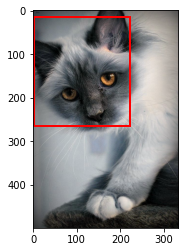

Size of original input:  (500, 334, 3)
Size of scaled input:  (128, 128, 3)


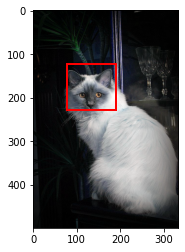

Size of original input:  (375, 500, 3)
Size of scaled input:  (128, 128, 3)


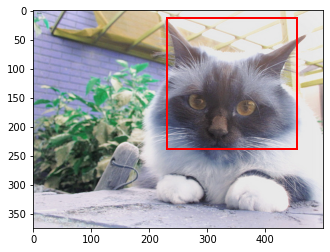

Size of original input:  (375, 500, 3)
Size of scaled input:  (128, 128, 3)


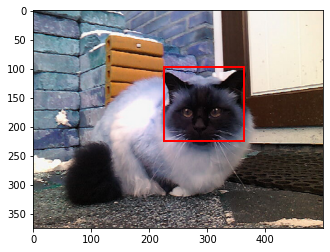

Size of original input:  (375, 500, 3)
Size of scaled input:  (128, 128, 3)


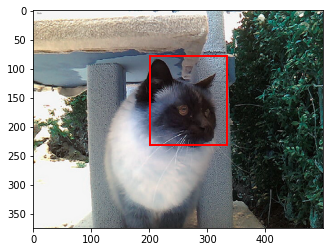

Size of original input:  (375, 500, 3)
Size of scaled input:  (128, 128, 3)


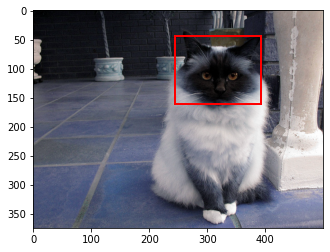

Size of original input:  (500, 500, 3)
Size of scaled input:  (128, 128, 3)


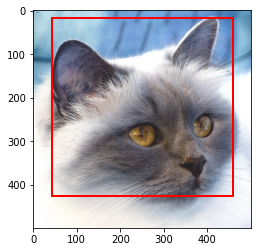

Size of original input:  (500, 362, 3)
Size of scaled input:  (128, 128, 3)


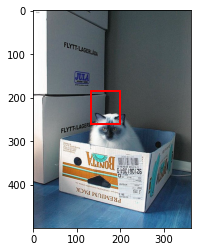

Size of original input:  (333, 500, 3)
Size of scaled input:  (128, 128, 3)


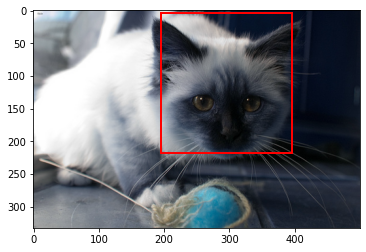

Size of original input:  (333, 500, 3)
Size of scaled input:  (128, 128, 3)


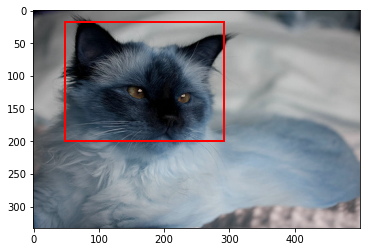

Size of original input:  (334, 500, 3)
Size of scaled input:  (128, 128, 3)


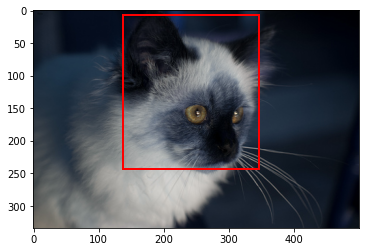

Size of original input:  (335, 500, 3)
Size of scaled input:  (128, 128, 3)


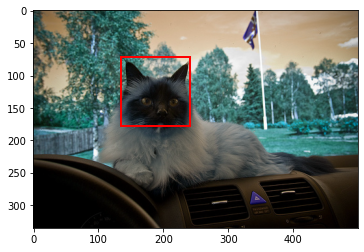

Size of original input:  (333, 500, 3)
Size of scaled input:  (128, 128, 3)


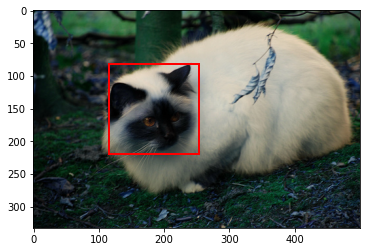

Size of original input:  (275, 183, 3)
Size of scaled input:  (128, 128, 3)


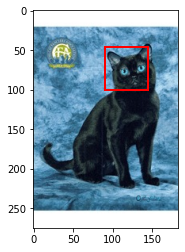

Size of original input:  (375, 500, 3)
Size of scaled input:  (128, 128, 3)


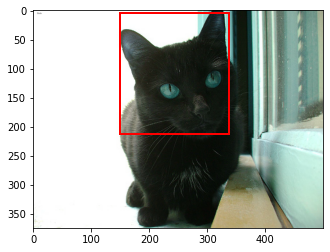

Size of original input:  (284, 300, 3)
Size of scaled input:  (128, 128, 3)


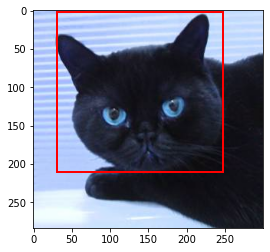

Size of original input:  (320, 450, 3)
Size of scaled input:  (128, 128, 3)


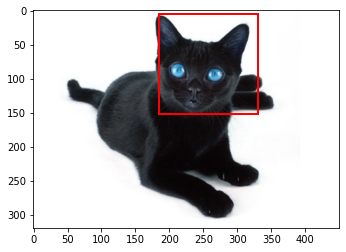

Size of original input:  (225, 300, 3)
Size of scaled input:  (128, 128, 3)


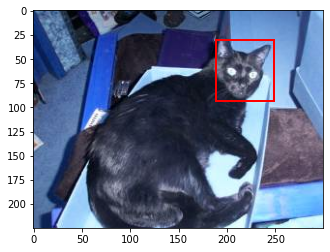

Size of original input:  (143, 114, 3)
Size of scaled input:  (128, 128, 3)


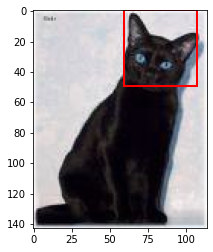

Size of original input:  (305, 360, 3)
Size of scaled input:  (128, 128, 3)


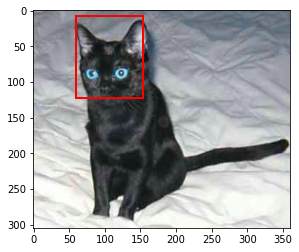

Size of original input:  (344, 290, 3)
Size of scaled input:  (128, 128, 3)


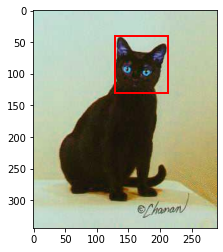

Size of original input:  (384, 577, 3)
Size of scaled input:  (128, 128, 3)


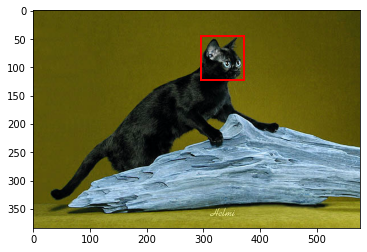

Size of original input:  (182, 200, 3)
Size of scaled input:  (128, 128, 3)


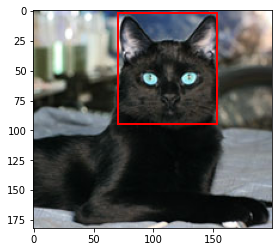

Size of original input:  (375, 500, 3)
Size of scaled input:  (128, 128, 3)


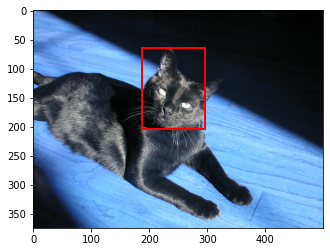

Size of original input:  (600, 909, 3)
Size of scaled input:  (128, 128, 3)


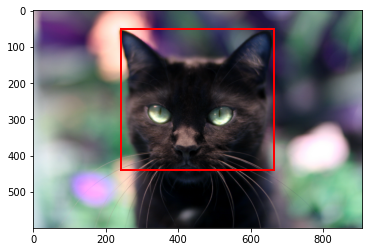

Size of original input:  (297, 450, 3)
Size of scaled input:  (128, 128, 3)


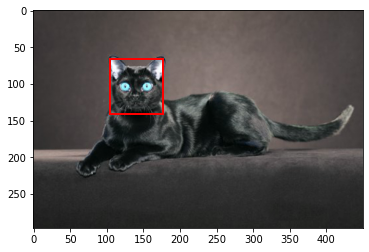

Size of original input:  (500, 334, 3)
Size of scaled input:  (128, 128, 3)


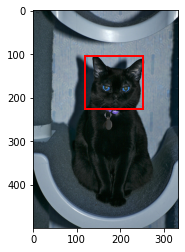

Size of original input:  (500, 404, 3)
Size of scaled input:  (128, 128, 3)


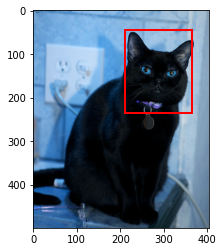

Size of original input:  (864, 1152, 3)
Size of scaled input:  (128, 128, 3)


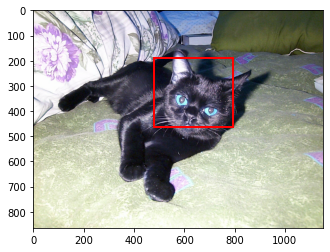

Size of original input:  (500, 438, 3)
Size of scaled input:  (128, 128, 3)


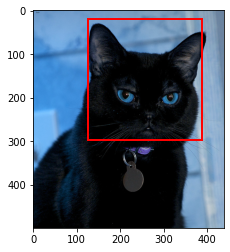

In [32]:
from tensorflow.keras.applications.mobilenet import preprocess_input
for i in df_val["path"][100:130]:
  filename = i
  orignolimage = cv2.imread(DATASET_FOLDER + filename)
  orignolimage_height, orignolimage_width, _ = orignolimage.shape
  image = cv2.resize(orignolimage, (128, 128)) # Rescaled image to run the network
  feat_scaled = preprocess_input(np.array(image, dtype=np.float32)) #passing it to mobilenet preprocessing
  print ("Size of original input: ", orignolimage.shape)
  print("Size of scaled input: ", feat_scaled.shape)
  predicted_bb = model.predict(x=np.array([feat_scaled]))[0]
  x0_rescaledback = int(predicted_bb[0] * orignolimage_width / 128) 
  y0_rescaledback = int(predicted_bb[1] * orignolimage_height / 128)
  x1_rescaledback = int((predicted_bb[0] + predicted_bb[2]) * orignolimage_width / 128)
  y1_rescaledback = int((predicted_bb[1] + predicted_bb[3]) * orignolimage_height / 128)
  
  fig,ax = plt.subplots(1)
  ax.imshow(orignolimage)
  rect = patches.Rectangle((x0_rescaledback, y0_rescaledback), x1_rescaledback - x0_rescaledback, y1_rescaledback - y0_rescaledback, linewidth=2, edgecolor='r', facecolor='none')
  ax.add_patch(rect)
  plt.show()

**Lets see how the model looks like:**

In [ ]:
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)       